## Mesh Extraction from a fixed Signed Distance Field (SDF)

In this example, we demonstrate how to use FlexiCubes to extract a mesh from a fixed signed distance field (SDF) **without** optimization. Note that in this case, the extraction scheme used is the original Dual Marching Cubes [Nielson 2004] algorithm, with minor improvements in splitting. To begin with, we will establish two functions: one for calculating the SDF of a cube, and another for determining its analytic gradient. In your specific application, the SDF might be predicted by a network, with gradients computed through methods such as finite differences or autograd.

In [1]:
import torch

def cube_sdf(x_nx3):
    sdf_values = 0.5 - torch.abs(x_nx3)
    sdf_values = torch.clamp(sdf_values, min=0.0)
    sdf_values = sdf_values[:, 0] * sdf_values[:, 1] * sdf_values[:, 2]
    sdf_values = -1.0 * sdf_values

    return sdf_values.view(-1, 1)


def cube_sdf_gradient(x_nx3):
    gradients = []
    for i in range(x_nx3.shape[0]):
        x, y, z = x_nx3[i]
        grad_x, grad_y, grad_z = 0, 0, 0

        max_val = max(abs(x) - 0.5, abs(y) - 0.5, abs(z) - 0.5)

        if max_val == abs(x) - 0.5:
            grad_x = 1.0 if x > 0 else -1.0
        if max_val == abs(y) - 0.5:
            grad_y = 1.0 if y > 0 else -1.0
        if max_val == abs(z) - 0.5:
            grad_z = 1.0 if z > 0 else -1.0

        gradients.append(torch.tensor([grad_x, grad_y, grad_z]))

    return torch.stack(gradients).to(x_nx3.device)

/home/frshen/anaconda3/envs/flexicubes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, let's call upon FlexiCubes to extract the mesh from this SDF, both with and without providing the gradient information.

In [2]:
import sys
sys.path.append('..')
from flexicubes import FlexiCubes
from util import *
res = 16
device='cuda'
fc = FlexiCubes(device)
x_nx3, cube_fx8 = fc.construct_voxel_grid(res)
x_nx3 *= 1.1 # add small margin to boundary
sdf_n = cube_sdf(x_nx3)
mesh_with_grad_v, mesh_with_grad_f, _ = fc(x_nx3, sdf_n, cube_fx8, res, grad_func=cube_sdf_gradient)
mesh_no_grad_v, mesh_no_grad_f, _ = fc(x_nx3, sdf_n, cube_fx8, res)

Now we visualize the two meshes. Without the gradient information, the extracted vertex locations are positioned at the centroids of the primal (Marching Cubes) mesh. Consequently, this method fails to reconstruct the sharp features present in the cube.

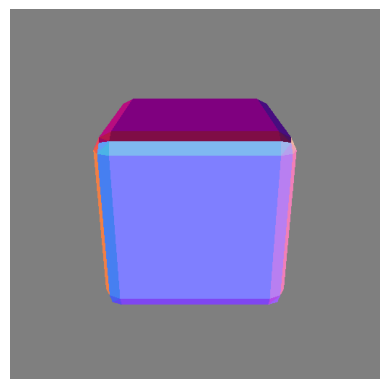

In [3]:
import render
import numpy as np
import matplotlib.pyplot as plt

mesh_no_grad = Mesh(mesh_no_grad_v, mesh_no_grad_f)
mesh_no_grad.auto_normals()
mv, mvp = render.get_rotate_camera(0, iter_res=[512,512], device=device)
val_buffers = render.render_mesh(mesh_no_grad, mv.unsqueeze(0), mvp.unsqueeze(0), [512,512], return_types=["normal"])
val_image = ((val_buffers["normal"][0].detach().cpu().numpy()+1)/2*255).astype(np.uint8)
plt.imshow(val_image)
plt.axis('off')
plt.show()

With the gradient function provided, the vertex location is defined as the minimizer of a Quadratic Error Function (QEF), akin to Dual Contouring [Schaefer et al. 2007], which preserves the sharp features. Unlike the approach in the original paper, when splitting the quadrilateral faces into triangles, we choose to split along the diagonal with a consistent gradient. This adjustment effectively reduces the visual artifacts in curved regions.

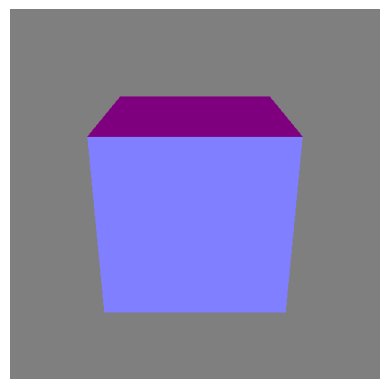

In [4]:
mesh_with_grad = Mesh(mesh_with_grad_v, mesh_with_grad_f)
mesh_with_grad.auto_normals()
mv, mvp = render.get_rotate_camera(0, iter_res=[512,512], device=device)
val_buffers = render.render_mesh(mesh_with_grad, mv.unsqueeze(0), mvp.unsqueeze(0), [512,512], return_types=["normal"])
val_image = ((val_buffers["normal"][0].detach().cpu().numpy()+1)/2*255).astype(np.uint8)
plt.imshow(val_image)
plt.axis('off')
plt.show()